<a href="https://colab.research.google.com/github/bladerunner666/Google-Search-Console-bulk-query/blob/master/Copy_of_Google_Trends_Seasonality_Index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Seasonality Index with Google Trends

A seasonality index is a forecasting tool used to determine demand for certain products or, in this case, search terms in a given market over the course of a typical year. Google Trends is a powerful tool that leverages the data collected by Google Search to quantify interest for a particular search term over time. We will use the past 5 years of Google Trends interest data to predict future interest over the next year in one-week spans.

## 1. Install Required Modules

In [0]:
from IPython.display import clear_output
!pip install pandas pytrends matplotlib numpy
clear_output()
print('All Installed.')

All Installed.


## 2. Import Required Modules

In [0]:
from pytrends.request import TrendReq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

## 3. Create Functions

We'll require two functions to create our seasonality index. The first, getTrends, will take a keyword and a dictionary object as parameters. This function will call the Google Trends API and append the data to a list stored in the dictionary object using the dates as a key.

The second function, average, will be used to calculate the average interest for each date in the dictionary.

In [0]:
def getTrends(keyword, data):
    pytrends = TrendReq()
    pytrends.build_payload([keyword], cat=0, timeframe='today 5-y', geo='US')
    df = pytrends.interest_over_time()
    for i, row in df.iterrows():
        i = str(i).split()[0]
        datetime.strptime(i, '%Y-%m-%d')
        if i not in data.keys():
            data[i] = [row[keyword]]
        else:
            data[i].append(row[keyword])
    return data
    
def average(lst):
    if len(lst) > 0:
        return sum(lst) / len(lst)
    else:
        return 0

## 4. Create Keyword List

In [0]:
# Replace the link below with the shareable link to your csv file
file_link = 'https://drive.google.com/open?id=1dVz1k5er3xHwdL-tont1zopWLJ0vGqJv'
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# Read CSV file and create Pandas dataframe.
fluff, id = file_link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('gsc_data.csv')  
df = pd.read_csv('gsc_data.csv')
df.head()

,Query,Clicks,Impressions,CTR,Position
0,new england patriots,10401,87114,11.94%,1.18
1,seattle seahaws,8269,22062,37.48%,1.61
2,carolina panthers,7132,48211,14.79%,3.76
3,new york jets,5162,96534,5.35%,4.11
4,green bay packers,5084,33609,15.13%,1.03


## 5. Query Google Trends

In [0]:
keywords = list(df['Query'])
data = {}

for keyword in keywords:
    data = getTrends(keyword, data)

## 6. Calculate Average Interest Over Time

In [0]:
for key, value in data.items():
    data[key] = [average(data[key])]
    
df = pd.DataFrame.from_dict(data, orient='index', columns=['Interest'])
df.index.rename('Date', inplace=True)
df = df.reset_index()
df.head()

,Date,Interest
0,2015-02-08,11.6
1,2015-02-15,5.8
2,2015-02-22,5.2
3,2015-03-01,7.4
4,2015-03-08,26.2


## 7. Plot Results

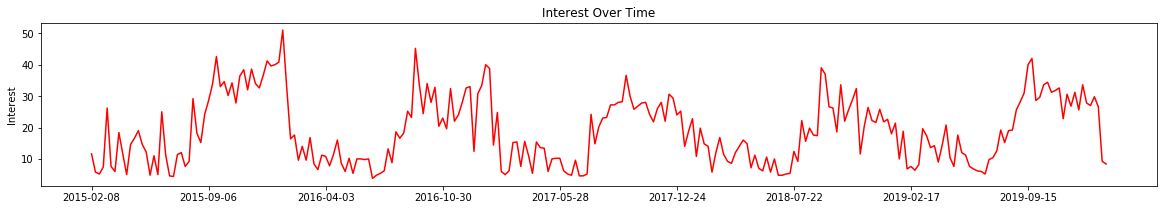

In [0]:
plt.plot_date(x=df.Date, y=df['Interest'], fmt="r-")
plt.title("Interest Over Time")
plt.ylabel("Interest")

xmarks = df.Date[0::30]
    
plt.xticks(xmarks)
plt.rcParams["figure.figsize"] = (20,3)
plt.show()

## 8. Group by Month

In order to calculate a monthly seasonality index, we need to group all of the search data over the last 5 years by month. We'll do this by converting the `YY-MM-DD` strings to `MM` strings and using Pandas to create a pivot table that aggregates average interest by month.



In [0]:
df = df.dropna()
df.Date = pd.to_datetime(df.Date)
df.Date = df.Date.dt.strftime('%B')


In [0]:
df_pivot = df.pivot_table(index='Date')
df_pivot = df_pivot.reset_index()
avg = df_pivot['Interest'].mean()
df_pivot['Seasonality Index'] = df_pivot['Interest'] / avg
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df_pivot['Date'] = pd.Categorical(df_pivot['Date'], categories=months, ordered=True)
df_pivot.sort_values('Date', ascending=True, inplace=True)
df_pivot

,Date,Interest,Seasonality Index
4,January,25.890909,1.372350
3,February,10.890000,0.577226
7,March,12.945455,0.686175
0,April,12.390909,0.656781
8,May,9.918182,0.525714
6,June,8.009524,0.424546
5,July,9.400000,0.498248
1,August,20.114286,1.066160
11,September,31.836364,1.687490
10,October,28.727273,1.522692


In [0]:
df_pivot.to_csv('seasonality_index.csv')